In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import tqdm
import ffmpeg
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib
import itertools

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [2]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [3]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

In [4]:
### load already created
hist_3d = np.load(os.path.join(cluster_dir, '20221210_3d_hists.npy'))
hist_3d.shape

(251, 2, 400, 25, 25)

In [5]:
### NORMALIZE ###
maxs = np.max(hist_3d,axis=(2,3,4))
hist_3d /= maxs[:,:,np.newaxis,np.newaxis,np.newaxis]

In [6]:
### NOTICE ###
# I am overwriting cluster 208 with cluster 99.
# 208 is some very noisy cluster that will be a singleton in the dendrogram, messing things up
# so I overwrote with a random adjacent cluster

hist_3d[208,...] = hist_3d[99,...]

In [237]:
### symmeterize
# probably a bad idea if I dont first fix the hist tilt
#hist_3d_sym = hist_3d[:,0,:,:,:] + hist_3d[:,1,:,:,:]

In [7]:
to_cluster = np.reshape(hist_3d[:,0,::2,:,:],(251,-1))
to_cluster.shape

(251, 125000)

In [ ]:
################################
### NOW MOVE TO NEXT SECTION ###
################################

In [121]:
t0 = time.time()
print('clustering.........')
n_clusters = 10
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
2.682095766067505


In [122]:
cmap = matplotlib.cm.get_cmap('gist_ncar')
colors_manual = cmap(np.linspace(0,1,n_clusters))

# visulize_clusters = np.zeros((314, 146, 91, 4)) # last axis is for color
# for cluster in range(251):
#     visulize_clusters[np.where(superclusters_250==cluster)] = colors_manual[model.labels_[cluster],:]

In [48]:
# plt.figure(figsize=(20,20))
# for j,z in enumerate(range(20,85,2)):
#     plt.subplot(7,7,j+1)
#     plt.imshow(np.swapaxes(visulize_clusters[:157,:,z,:],0,1))
#     plt.axis('off')

In [61]:
cluster_hists = []
for label in np.unique(model.labels_):
    ind = np.where(model.labels_==label)[0]
    cluster_hists.append(np.mean(hist_3d[ind,0,...],axis=0))

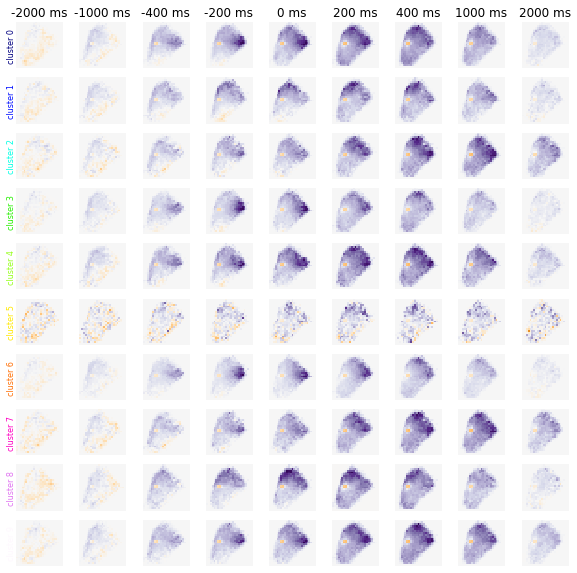

In [64]:
cluster_ = 0

plt.figure(figsize=(10,10))

tps = [100,150,180,190,200,210,220,250,300]

graph_idx = 0
for cluster_ in range(n_clusters):
    
    vmax = np.max(cluster_hists[cluster_])

    for j,tp in enumerate(tps):
        graph_idx+=1
        plt.subplot(n_clusters,len(tps),graph_idx)
        plt.imshow(cluster_hists[cluster_][tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
        plt.axis('off')
        if j==0:
            plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=8,color=colors_manual[cluster_])
        if cluster_==0:
            plt.title(F"{(tp-200)*20} ms")
            
    #plt.subplots_adjust(wspace=-.001)

In [8]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    plt.figure(figsize=(10,10))
    dendrogram(linkage_matrix, **kwargs)

In [9]:
ii = itertools.count(to_cluster.shape[0])
nodes = [{'node_id': next(ii), 'left': x[0], 'right':x[1]} for x in model.children_]

In [10]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [33]:
n_colors = 251
master_cmap = 'gist_ncar'

n_samples = len(nodes) + 1
children_tracker = []

for i in range(len(nodes)):
    left_child = nodes[i]['left']
    right_child = nodes[i]['right']
    num_left_children = 0
    num_right_children = 0
    children_tracker.append({'children': [], 'engulfed_nodes': [i]})
        
    # LEFT CHILD
    if left_child < n_samples:
        children_tracker[-1]['children'].extend([left_child])
    else:
        index = left_child - n_samples
        children_tracker[-1]['children'].extend(children_tracker[index]['children'])
        num_left_children = len(children_tracker[index]['children'])
        
        children_tracker[-1]['engulfed_nodes'].extend(children_tracker[index]['engulfed_nodes'])
    
    # RIGHT CHILD
    if right_child < n_samples:
        children_tracker[-1]['children'].extend([right_child])
    else:
        index = right_child - n_samples
        children_tracker[-1]['children'].extend(children_tracker[index]['children'])
        num_right_children = len(children_tracker[index]['children'])
        
        children_tracker[-1]['engulfed_nodes'].extend(children_tracker[index]['engulfed_nodes'])
        
    # ASSIGN COLOR
    if right_child < n_samples and left_child < n_samples:
        children_tracker[-1]['color'] = random.randint(1, n_colors-1)
    else:
        if num_right_children > num_left_children:
            index = right_child - n_samples
            children_tracker[-1]['color'] = children_tracker[index]['color']
        else:
            index = left_child - n_samples
            children_tracker[-1]['color'] = children_tracker[index]['color']
            
# # CREATE BRAIN COLORS OVER TIME

# brain_colored = np.zeros((n_samples,n_samples))

# for i in range(len(nodes)):
#     brain_colored[i+1,:] = brain_colored[i,:]
#     brain_colored[i+1,:][children_tracker[i]['children']] = children_tracker[i]['color']
    
# brain_colored_toplot = np.reshape(brain_colored, (9856,77,128))
# brain_colored_toplot[brain_colored_toplot == 0] = 'nan'
# print(brain_colored_toplot.shape)

# CREATE DENDROGRAM COLORS OVER TIME
# here, when a node gets a color, I want all of it's children to get that same color
# need a way to track which nodes were engulfed in other nodes

dendrogram_colored = np.zeros((n_samples,n_samples))

for i in range(len(nodes)):
    dendrogram_colored[i+1,:] = dendrogram_colored[i,:]
    dendrogram_colored[i+1,:][children_tracker[i]['engulfed_nodes']] = children_tracker[i]['color'] # give new node color
    
dendrogram_colored = dendrogram_colored.astype(int)
print(dendrogram_colored.shape)

(251, 251)


In [15]:
import random
import matplotlib as mpl

In [82]:
### RUN FIRST ROUND OF CLUSTERING WITH FULL CLUSTERING
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)

### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

## RUN 2ND ROUND OF CLUSTERING WITH n_clusters
n_clusters = 10
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)

cluster_colors = []
for cluster in range(251):
    cluster_colors.append(list(colors_manual[model.labels_[cluster],:]))
cluster_colors = np.asarray(cluster_colors)


In [91]:
model.labels_

array([9, 9, 0, 9, 4, 3, 0, 9, 9, 0, 0, 1, 1, 9, 1, 2, 2, 3, 6, 0, 9, 1,
       9, 9, 9, 0, 0, 1, 2, 0, 4, 2, 3, 2, 9, 2, 0, 2, 3, 9, 9, 9, 9, 0,
       7, 2, 9, 3, 9, 9, 9, 9, 9, 2, 9, 7, 2, 8, 2, 0, 9, 2, 6, 9, 4, 0,
       2, 2, 2, 0, 3, 2, 9, 0, 3, 9, 0, 8, 0, 7, 8, 4, 2, 9, 9, 8, 3, 2,
       9, 9, 9, 0, 2, 2, 4, 0, 4, 3, 9, 0, 2, 0, 0, 9, 0, 0, 2, 2, 9, 6,
       0, 8, 8, 9, 0, 0, 2, 0, 9, 0, 2, 2, 9, 0, 0, 4, 4, 2, 8, 9, 9, 9,
       9, 9, 9, 3, 0, 4, 0, 0, 9, 0, 1, 4, 0, 9, 2, 0, 9, 6, 6, 0, 6, 9,
       9, 9, 3, 0, 0, 6, 1, 9, 4, 0, 4, 8, 9, 4, 0, 2, 9, 7, 3, 9, 2, 3,
       3, 7, 9, 0, 1, 4, 6, 7, 2, 8, 8, 3, 9, 0, 7, 9, 9, 7, 9, 3, 0, 2,
       1, 4, 0, 2, 2, 6, 2, 0, 0, 9, 5, 2, 0, 7, 9, 6, 9, 0, 2, 9, 4, 2,
       2, 7, 9, 3, 1, 0, 4, 8, 9, 0, 9, 9, 4, 3, 3, 9, 0, 1, 9, 0, 2, 3,
       0, 0, 9, 8, 6, 0, 0, 6, 0])

In [90]:
dendrogram_colored[timepoint,:]

array([246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246, 246,
       246, 246, 246, 246, 246,  95,  95, 246, 246, 246, 246,  67, 246,
       246, 246, 246, 246,  95, 246, 246,  67, 246, 246, 246, 246, 246,
       246,  95, 246, 246,  95,  95,  67, 246, 246,  95,  67,  67,  95,
       246, 246, 246,  64, 246,  95,  67, 179, 246, 246, 101,  67,  95,
       246,  95,  67,  67,  95, 246,  95, 175,  95,  67,  67,  67,  67,
       246,  67,  95,  67,  95, 101,  64,  95,  67,  95,  64,  67,  67,
        67,  67,  95,  67,  67, 175,  67,  67,  95, 246, 175, 246, 246,
        67,  95, 179,  95, 175,  64,  67,  67, 235,  95, 246,  95,  67,
        95,  64,  67, 139, 175,  67, 246,  64, 246,  95,  95,  67, 235,
       235,  67, 175,  64, 101, 246, 101, 179,  67, 139, 179, 235, 175,
       246,  95,  67,  67,  64,  67,  67, 175,  67,  95, 179, 101, 101,
        67, 246, 235,  64, 101, 246, 139, 179, 235,  64, 101,  67, 246,
        67,  67,  67, 246,  95, 139,  67,  95, 235, 179,  95, 13

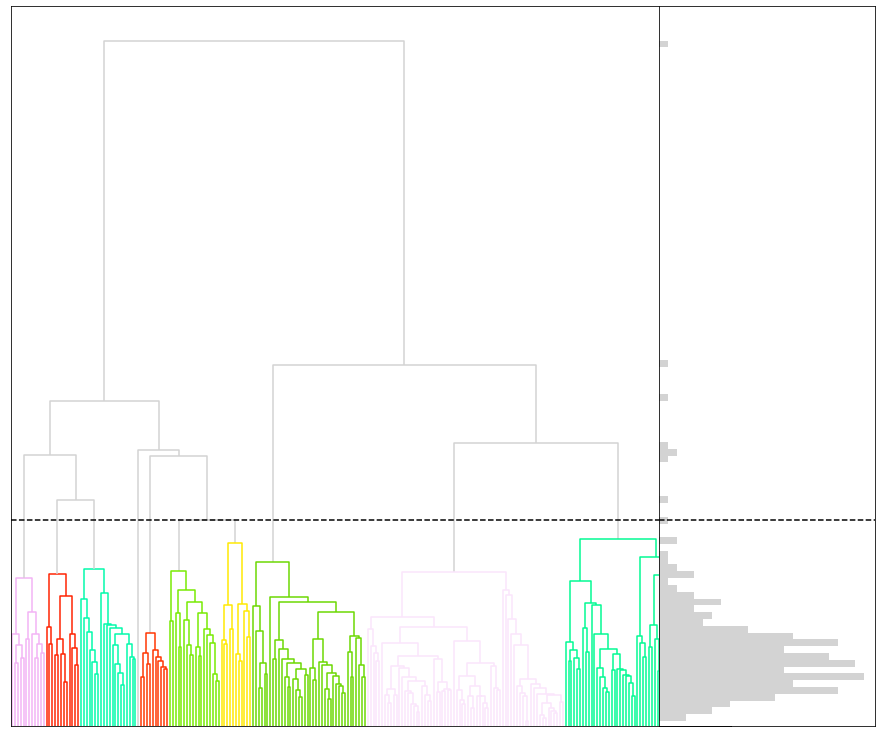

In [89]:
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

timepoint = 251-10

cmap = getattr(cm, master_cmap)(np.linspace(0, 1, n_colors)) # make the n_colors possible colors in rgba
temp_colors = cmap[dendrogram_colored[timepoint,:],:] # index into these colors using cluster color_ids
true_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in temp_colors] # convert to hex

cmap = cm.Greys(np.linspace(0, 1, n_samples))
throwaway_colors = [mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap]
colors = throwaway_colors + true_colors # add throwaway colors to frontend
colors[n_samples+timepoint:] = [background_color]*(n_samples-timepoint) # add grey to non-clusted samples

ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
ax_dendrogram.get_xaxis().set_visible(False)
ax_dendrogram.get_yaxis().set_visible(False)
dendrogram(linkage_matrix,
           truncate_mode=None,
           p=10000,
           color_threshold=None,
           link_color_func=lambda x: colors[x],
           no_labels=True,
           distance_sort=True);
try:
    plt.axhline(linkage_matrix[timepoint,2],color='k',linestyle='--')
except:
    print('axhline failed')
    

ax_dend_hist = fig.add_axes([2, 0, .3, 1],sharey=ax_dendrogram)
ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
try:
    ax_dend_hist.axhline(linkage_matrix[timepoint,2],color='k',linestyle='--')
except:
    print('axhline failed')
ax_dend_hist.get_xaxis().set_visible(False)
ax_dend_hist.get_yaxis().set_visible(False)

# fresh, this is good

In [ ]:
### next work:
# need to match colors between dendrogram and the below plots
# dendrogram gets set with
# hierarchy.set_link_color_palette(cluster_colors)
# probably easiest to just shuffle the cluster_colors into the correct order to match them to below


In [8]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from matplotlib import colors

In [9]:
to_cluster.shape

(251, 125000)

In [261]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
1.6005020141601562


In [262]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [263]:
n_clusters = 15

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

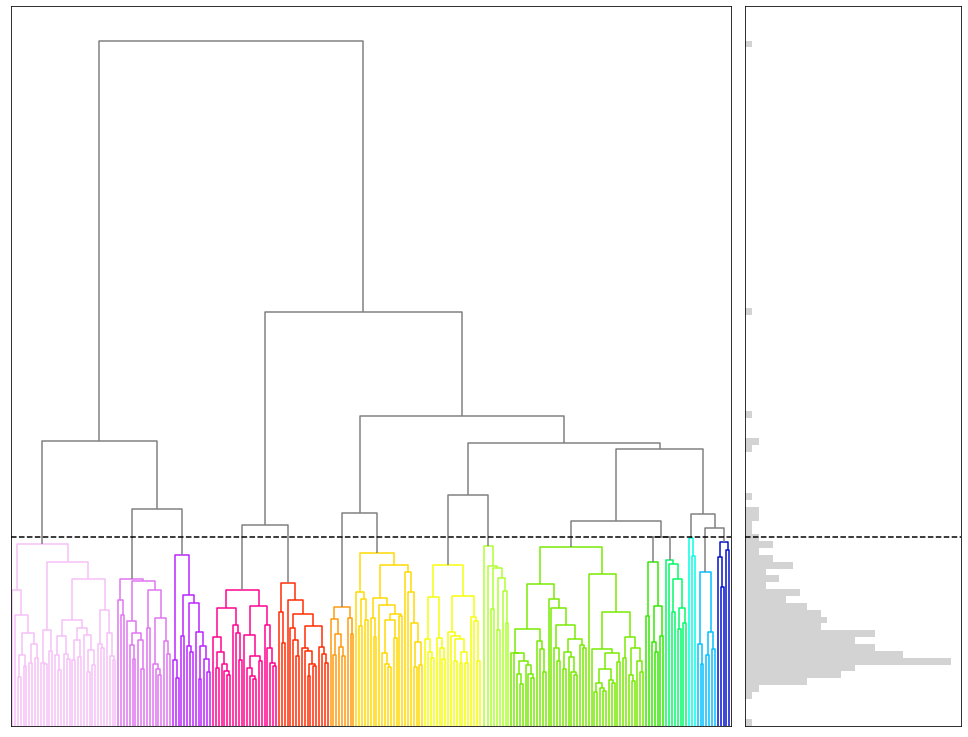

In [264]:
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
ax_dendrogram.get_xaxis().set_visible(False)
ax_dendrogram.get_yaxis().set_visible(False)
dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey');
try:
    plt.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')

ax_dend_hist = fig.add_axes([2.12, 0, .3, 1],sharey=ax_dendrogram)
ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
try:
    ax_dend_hist.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')
ax_dend_hist.get_xaxis().set_visible(False)
ax_dend_hist.get_yaxis().set_visible(False)

In [265]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=None, #first run with =0. Then change to None
                                n_clusters=n_clusters, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(to_cluster)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.4225189685821533


In [266]:
# cluster_hists = []
# for label in np.unique(model.labels_):
#     ind = np.where(model.labels_==label)[0]
#     cluster_hists.append(np.mean(hist_3d[ind,0,...],axis=0))

In [267]:
cluster_hists = []
for label in np.unique(cluster_ids):
    ind = np.where(cluster_ids==label)[0]
    cluster_hists.append(np.mean(hist_3d[ind,0,...],axis=0))

In [268]:
# ### FIND CORRECT NEW ORDER OF CLUSTER IDs
# # based on hierarchy.set_link_color_palette and the cluster_ids
# cluster_idx_shuffle = []
# for i in np.unique(model.labels_):
#     idx = np.where(model.labels_==i)[0][0]
#     cluster_idx_shuffle.append(cluster_ids[idx])

# # turn to zero index
# cluster_idx_shuffle = [i-1 for i in cluster_idx_shuffle]

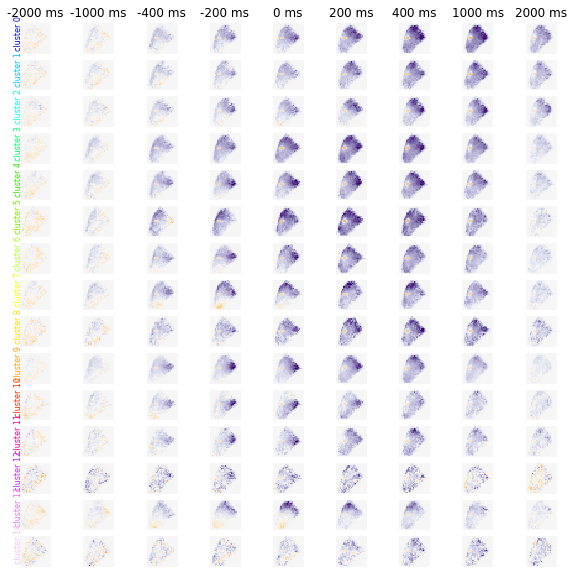

In [269]:
plt.figure(figsize=(10,10))

tps = [100,150,180,190,200,210,220,250,300]

graph_idx = 0
for cluster_ in np.unique(cluster_ids):
        
    #new_cluster = cluster_idx_shuffle[cluster_]
    
    vmax = np.max(cluster_hists[cluster_])

    for j,tp in enumerate(tps):
        graph_idx+=1
        plt.subplot(n_clusters,len(tps),graph_idx)
        plt.imshow(cluster_hists[cluster_][tp,:,:],cmap='PuOr',vmin=-vmax,vmax=vmax,extent=[-2.35,6,-4.35,4])
        plt.axis('off')
        if j==0:
            plt.text(-4,-3,F"cluster {cluster_}",rotation=90,fontsize=8,color=cluster_colors[cluster_])
        if cluster_==0:
            plt.title(F"{(tp-200)*20} ms")
            
    #plt.subplots_adjust(wspace=-.001)

In [270]:
visulize_clusters = np.zeros((314, 146, 91, 4)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(251):
    visulize_clusters[np.where(superclusters_250==cluster)] = custom_cmap[cluster_ids[cluster],:]
    

In [275]:
np.unique(cluster_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int32)

In [311]:
### SPECIAL LOW ALPHA VERSION TO HIGHLIGHT A SPECIFIC CLUSTER

custom_cmap_low_alpha = custom_cmap.copy()
custom_cmap_low_alpha[:,3] = .2

visulize_clusters = np.zeros((314, 146, 91, 4)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(251):
    if cluster_ids[cluster] == 15:
        visulize_clusters[np.where(superclusters_250==cluster)] = custom_cmap[cluster_ids[cluster],:]
    else:
        # decrease alpha
        visulize_clusters[np.where(superclusters_250==cluster)] = custom_cmap_low_alpha[cluster_ids[cluster],:]

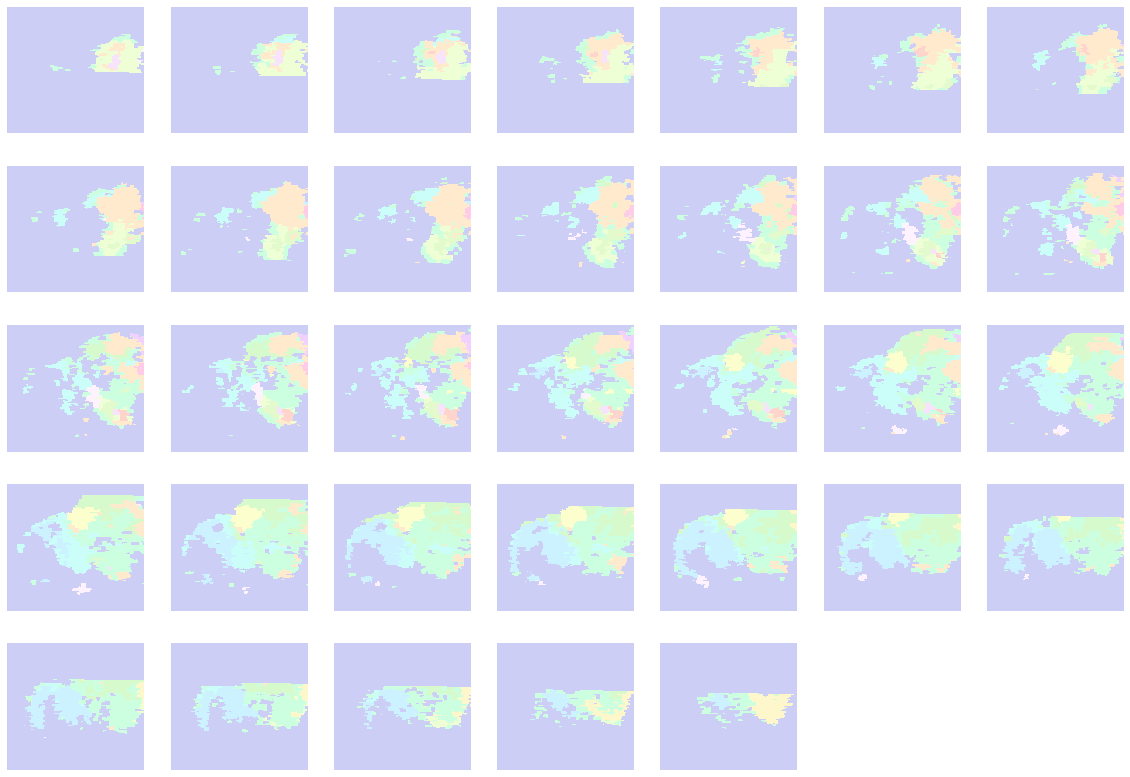

In [312]:
plt.figure(figsize=(20,20))
for j,z in enumerate(range(20,85,2)):
    plt.subplot(7,7,j+1)
    plt.imshow(np.swapaxes(visulize_clusters[:157,:,z,:],0,1))
    plt.axis('off')

In [144]:
visulize_clusters = np.zeros((314, 146, 91))
for cluster in range(251):
    visulize_clusters[np.where(superclusters_250==cluster)] = cluster_ids[cluster] + 2

In [145]:
temporal_map = visulize_clusters

In [146]:
input_canvas = np.zeros((500,500))

x_shift=0; y_shift=0
data_map, contours = plot_grouped_roi_image(FB_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=-45
data_map, contours = plot_grouped_roi_image(PB.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=0; y_shift=35
data_map, contours = plot_grouped_roi_image({23: 'EB'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##########
### MB ###
##########

# x_shift=60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_left_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
# x_shift=-60; y_shift=-50
# data_map, contours = plot_grouped_roi_image(MB_right_group.keys(), plot=False)
# canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

#################
### BIG GROUP ###
#################

x_shift=-130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_r_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=130; y_shift=30
data_map, contours = plot_grouped_roi_image(big_l_group.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

##############
### VISUAL ###
##############

x_shift=-200; y_shift=175
data_map, contours = plot_grouped_roi_image({25: 'MED_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=200; y_shift=175
data_map, contours = plot_grouped_roi_image({71: 'MED_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({3: 'LO_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=40+175
data_map, contours = plot_grouped_roi_image({53: 'LO_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

x_shift=-140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({22: 'LP_R'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
x_shift=140; y_shift=-30+175
data_map, contours = plot_grouped_roi_image({69: 'LP_L'}.keys(), plot=False)
canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)

canvas = wraper_wraper(canvas, ventromedial_r_group.keys(), y_shift=55, x_shift=-50)
canvas = wraper_wraper(canvas, ventromedial_l_group.keys(), y_shift=55, x_shift=50)

canvas = wraper_wraper(canvas, anterior_group.keys(), y_shift=150, x_shift=0)

canvas = wraper_wraper(canvas, {34: 'AOTU_R'}.keys(), y_shift=-50+175-15, x_shift=-80)
canvas = wraper_wraper(canvas, {79: 'AOTU_L'}.keys(), y_shift=-50+175-15, x_shift=80)

canvas[np.where(canvas==0)] = np.nan

In [147]:
cluster_colors_for_brain = cluster_colors[:]
cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

(-0.5, 499.5, 349.5, -0.5)

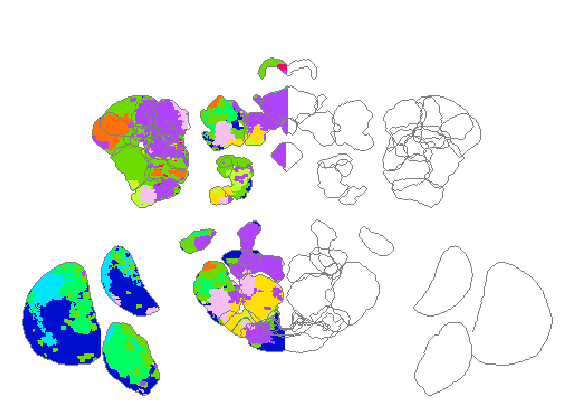

In [148]:
plt.figure(figsize=(10,10))
plt.imshow(canvas[150:,:],cmap=cmap)
plt.axis('off')

In [75]:
import brainsss
atlas_clean = brainsss.load_roi_atlas()
explosion_rois = brainsss.load_explosion_groups()
all_rois = brainsss.unnest_roi_groups(explosion_rois)
roi_masks = brainsss.make_single_roi_masks(all_rois, atlas_clean)
roi_contours = brainsss.make_single_roi_contours(roi_masks, atlas_clean)

In [77]:
def plot_grouped_roi_image(rois,plot=True):
    roi_data = []
    roi_contours = []

    left_edges = []
    right_edges = []
    bottom_edges = []
    top_edges = []

    for roi in rois:
        ####################
        ### Get roi mask ###
        ####################

        mask = np.zeros(atlas_clean.shape)
        mask[np.where(atlas_clean == roi)] = 1

        mask_eroded = binary_erosion(mask, structure=np.ones((2,2,2)))
        mask_dilated = binary_dilation(mask_eroded, iterations=2)

        # temporal
        masked_roi = mask_dilated*temporal_map #CORR
        masked_roi_flat = np.max(masked_roi,axis=2)
        roi_data.append(masked_roi_flat)
        
        #PCA
#         masked_roi = mask_dilated*pca_map
#         maxs = np.max(masked_roi,axis=2)
#         mins = np.min(masked_roi,axis=2)
#         maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#         masked_roi_flat = maxs
#         roi_data.append(masked_roi_flat)
    
        #######################
        ### Get roi contour ###
        #######################
        
        _, mask_binary = cv2.threshold(np.max(mask_dilated,axis=-1).astype('uint8'), 0, 1, cv2.THRESH_BINARY) 
        contours, _ = cv2.findContours(mask_binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#cv2.RETR_TREE

        canvas = np.ones(atlas_clean[:,:,0].shape)
        out = cv2.drawContours(canvas, contours, -1, (0,255,0), 1)
        out = np.abs(out-1) #flip 0/1
        roi_contour = np.repeat(out[:,:,np.newaxis],repeats=4,axis=-1) ### copy into rgba channels to make white
        roi_contours.append(roi_contour)

        # for plotting
        left_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][0])
        right_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=0)>0)[0][-1])
        top_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][0])
        bottom_edges.append(np.where(np.sum(np.nan_to_num(roi_contour),axis=1)>0)[0][-1])
        
    # get extreme edges from all rois used
    left_edge = np.min(left_edges) - 1
    right_edge = np.max(right_edges) + 1
    top_edge = np.min(top_edges) - 1
    bottom_edge = np.max(bottom_edges) + 1

    ############
    ### PLOT ###
    ############
    
    roi_datas = np.max(np.asarray(roi_data),axis=0)
    data_map = np.swapaxes(roi_datas[top_edge:bottom_edge,left_edge:right_edge],0,1)
    
    #PCA
#     roi_data = np.asarray(roi_data)
#     maxs = np.max(roi_data,axis=0)
#     mins = np.min(roi_data,axis=0)
#     maxs[np.where(np.abs(mins)>maxs)] = mins[np.where(np.abs(mins)>maxs)]
#     data_map = np.swapaxes(maxs[top_edge:bottom_edge,left_edge:right_edge],0,1)

    if plot:
        plt.figure(figsize=(10,10))
        plt.imshow(data_map)

    contours_to_export = []
    for i in range(len(roi_contours)):
        single_contour = np.swapaxes(roi_contours[i][top_edge:bottom_edge,left_edge:right_edge],0,1)
        contours_to_export.append(single_contour)
        if plot:
            plt.imshow(single_contour)
        
    return data_map, contours_to_export

def place_on_canvas(input_canvas, to_plot, is_contour=False, is_midline=True, x_shift=0, y_shift=0):
    full_y_mid = int(input_canvas.shape[0]/2)
    full_x_mid = int(input_canvas.shape[1]/2)

    y_mid = int(to_plot.shape[0]/2)
    x_mid = int(to_plot.shape[1]/2)

    height = to_plot.shape[0]
    width = to_plot.shape[1]

    left = full_x_mid-x_mid
    right = left + width

    top = full_y_mid-y_mid
    bottom = top + height

    if is_contour:
        ys = np.where(to_plot[:,:,0]>0)[0] + full_y_mid - y_mid + y_shift
        xs = np.where(to_plot[:,:,0]>0)[1] + full_x_mid - x_mid + x_shift
        input_canvas[ys,xs]=1
    else:
        #input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift,:3] = to_plot
        input_canvas[top+y_shift:bottom+y_shift,left+x_shift:right+x_shift] = to_plot #pca
    return input_canvas

def place_on_canvas_wrapper(canvas, data_map, contours, y_shift, x_shift):
    canvas = place_on_canvas(canvas, to_plot=data_map, y_shift=y_shift, x_shift=x_shift)
    for i in range(len(contours)):
        canvas = place_on_canvas(canvas, to_plot=contours[i], is_contour=True, y_shift=y_shift, x_shift=x_shift)
    return canvas

def wraper_wraper(canvas, roi_ids, y_shift, x_shift):
    data_map, contours = plot_grouped_roi_image(roi_ids, plot=False)
    canvas = place_on_canvas_wrapper(input_canvas, data_map, contours, y_shift=y_shift, x_shift=x_shift)
    return canvas

In [78]:
##################
### ROI GROUPS ###
##################

FB_group = {
26: 'FB',
4: 'NO',
5: 'BU_R',
54: 'BU_L',
8: 'LAL_R',
56: 'LAL_L',
31: 'PVLP_R',
76: 'PVLP_L'}

ventromedial_r_group = {
13: 'VES_R',  
40: 'EPA_R',
35: 'GOR_R',
11: 'AMMC_R'}

ventromedial_l_group = {
60: 'VES_L', 
85: 'EPA_L',
80: 'GOR_L',
58: 'AMMC_L'}

PB = {6: 'PB'}
EB = {23: 'EB'}

anterior_group = {
50: 'PRW',
9: 'SAD',
49: 'GNG',
30: 'AVLP_R',
75: 'AVLP_L',
24: 'AL_R',
70: 'AL_L',
64: 'MB_PED_L',
65: 'MB_VL_L',
66: 'MB_ML_L',
81: 'MB_CA_L',
17: 'MB_PED_R',
18: 'MB_VL_R',
19: 'MB_ML_R',
36: 'MB_CA_R',
32: 'IVLP_R',
77: 'IVLP_L',
10: 'CAN_R',
20: 'FLA_R',
57: 'CAN_L',
67: 'FLA_L'}

big_r_group = {
27: 'SLP_R',
29: 'SMP_R',
33: 'PLP_R',
7: 'LH_R',
38: 'IPS_R',
37: 'SPS_R',
16: 'CRE_R',
39: 'SCL_R',
12: 'ICL_R',
15: 'ATL_R',
14: 'IB_R',
28: 'SIP_R'}
    
big_l_group = {
72: 'SLP_L',   
74: 'SMP_L',
78: 'PLP_L',
55: 'LH_L',
83: 'IPS_L',
82: 'SPS_L',
63: 'CRE_L',
84: 'SCL_L',  
59: 'ICL_L',
62: 'ATL_L',
61: 'IB_L',
73: 'SIP_L'}